In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [4]:
categorical = y2015.select_dtypes(include=['object'])
categorical.nunique()

id                           421097
term                              2
int_rate                        110
grade                             7
sub_grade                        35
emp_title                    120812
emp_length                       11
home_ownership                    4
verification_status               3
issue_d                          12
loan_status                       7
pymnt_plan                        1
url                          421095
desc                             34
purpose                          14
title                            27
zip_code                        914
addr_state                       49
earliest_cr_line                668
revol_util                     1211
initial_list_status               2
last_pymnt_d                     25
next_pymnt_d                      4
last_credit_pull_d               26
application_type                  2
verification_status_joint         3
dtype: int64

Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [5]:
y2015['int_rate'].head()

0     14.85%
1      7.49%
2      7.49%
3      6.49%
4     19.89%
Name: int_rate, dtype: object

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [7]:
y2015.isnull().sum()

id                                     2
member_id                              2
loan_amnt                              2
funded_amnt                            2
funded_amnt_inv                        2
term                                   2
int_rate                               2
installment                            2
grade                                  2
emp_length                         23819
home_ownership                         2
annual_inc                             2
verification_status                    2
issue_d                                2
loan_status                            2
pymnt_plan                             2
purpose                                2
title                                134
dti                                    2
delinq_2yrs                            2
inq_last_6mths                         2
mths_since_last_delinq            203964
mths_since_last_record            346682
open_acc                               2
pub_rec         

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [8]:
y2015[y2015['id'].isnull()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [37]:
pd.get_dummies(y2015).columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       ...
       'last_credit_pull_d_Nov-2016', 'last_credit_pull_d_Oct-2015',
       'last_credit_pull_d_Oct-2016', 'last_credit_pull_d_Sep-2015',
       'last_credit_pull_d_Sep-2016', 'application_type_INDIVIDUAL',
       'application_type_JOINT', 'verification_status_joint_Not Verified',
       'verification_status_joint_Source Verified',
       'verification_status_joint_Verified'],
      dtype='object', length=237)

It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [38]:
# see how many columns has null value
test = y2015.isnull().sum()
len(test[test>0])

35

In [30]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)
X.shape

cross_val_score(rfc, X, Y, cv=10)

(421095, 201)

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [42]:
# check how many columns 
X.shape

(421095, 201)

We first try to apply PCA on cleaned data with the dummy columns together, since PCA will be affected by the original value, we will have to normalize each feature before applying

In [18]:
len(y2015.dropna(axis=1).select_dtypes(['number']).columns)

58

In [16]:
len(y2015.dropna(axis=1).select_dtypes(['object']).columns)

Index(['term', 'grade', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status',
       'application_type'],
      dtype='object')

In [23]:
# approach 1
# perform PCA on cleaned data without the dummy columns
# normalize the numeric variables before performing PCA
from sklearn.preprocessing import scale

# isolate the numeric variable
X_1 = scale(y2015.dropna(axis=1).select_dtypes(['number']))
y_1 = y2015.dropna(axis=1)['loan_status']

In [26]:
from sklearn.decomposition import PCA
# try 10 components first
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_1)
pca_df = pd.DataFrame(data = principalComponents, columns = list(range(1,11)))
pca_df = pd.concat([pca_df, y_1], axis=1)
pca_df.head()

,1,2,3,4,5,6,7,8,9,10,loan_status
0,3.587556,1.542228,2.500079,-2.773611,3.408671,1.467261,-0.920762,4.500378,-0.110521,-0.193243,Current
1,-3.384063,-0.562259,1.331779,-0.835384,0.572886,-1.392441,-0.884068,-0.585214,-1.520458,-0.162051,Current
2,2.394113,-4.347264,-1.491743,2.668561,2.177444,-0.731460,-1.979200,0.087153,-2.835595,-0.696067,Fully Paid
3,4.207465,-0.860229,1.954085,-3.130148,2.049866,1.005176,-0.597040,0.154247,-0.970431,-0.883438,Current
4,-0.160651,5.590080,-3.166568,0.729965,-2.985111,-1.984900,-2.237551,2.440572,-2.571400,0.775232,Fully Paid


In [28]:
# show how much variance is explained by n_components=10
pca.explained_variance_ratio_.sum()

0.6384755170307805

Looks like there is around 63.85% retained with n_components = 10, let us use the model to train to see what are the cv scores

In [29]:
# check the model performace
cross_val_score(rfc, pca_df.drop('loan_status', axis=1), pca_df['loan_status'], cv=10)

array([0.8829047 , 0.89684405, 0.89881504, 0.90076227, 0.89658038,
       0.89033484, 0.88368282, 0.88534518, 0.89659677, 0.81427825])

We can see that our first approach was not that successful, only one of the scores is higher than 90% and it ranges from 81.43% to 90.08%, which varies quite a lot

In [39]:
X_1.shape

(421095, 58)

In [40]:
# approach 2
# use the approach 1 plus the dummy variables

# get dummy variables from object dtype 
dummy = pd.get_dummies(y2015.dropna(axis=1).drop('loan_status', axis=1).select_dtypes(['object']))

# concatenate pca_df generated previously and dummy variables
pca_df2 = pd.concat([pca_df, dummy], axis=1)

In [43]:
pca_df2.head()

,1,2,3,4,5,6,7,8,9,10,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT
0,3.587556,1.542228,2.500079,-2.773611,3.408671,1.467261,-0.920762,4.500378,-0.110521,-0.193243,...,0,0,0,0,0,0,0,1,1,0
1,-3.384063,-0.562259,1.331779,-0.835384,0.572886,-1.392441,-0.884068,-0.585214,-1.520458,-0.162051,...,0,0,0,0,0,0,0,1,1,0
2,2.394113,-4.347264,-1.491743,2.668561,2.177444,-0.731460,-1.979200,0.087153,-2.835595,-0.696067,...,0,0,0,0,0,0,0,1,1,0
3,4.207465,-0.860229,1.954085,-3.130148,2.049866,1.005176,-0.597040,0.154247,-0.970431,-0.883438,...,0,0,0,0,0,0,0,1,1,0
4,-0.160651,5.590080,-3.166568,0.729965,-2.985111,-1.984900,-2.237551,2.440572,-2.571400,0.775232,...,0,0,0,0,0,0,0,1,1,0


We can see by using only the numerical columns that are existing in the original data, with the same n_components we are able to reach around 63.85% explained variance

In [44]:
# check the model performace
cross_val_score(rfc, pca_df2.drop('loan_status', axis=1), pca_df2['loan_status'], cv=10)

array([0.8051103 , 0.85072784, 0.81641376, 0.85239011, 0.83709333,
       0.80719544, 0.60775606, 0.79218219, 0.53041062, 0.49772004])

From above we can see that the performance is actually worse than approach 1, the average scores is worse and the variance is quite high

In [45]:
# approach 3
# let's try using only dummy variables to see how it works
cross_val_score(rfc, dummy, y2015['loan_status'], cv=10)

array([0.67920496, 0.62463489, 0.61634727, 0.47277433, 0.23191641,
       0.21151745, 0.24099361, 0.36244033, 0.29643527, 0.26414288])

Approach 3 is not working well either since the dummy variables might not have enough information

In [48]:
# approach 4
# this time we use a different parameters for setting our pca model, instead of specify n_components, we set up a
# 85% explained variance criteria and later to see how many n_components it require
pca_4 = PCA(0.85)
principalComponents = pca_4.fit_transform(X_1)
pca_df4 = pd.DataFrame(data = principalComponents, columns = list(range(1,pca_4.n_components_ + 1)))
pca_df4 = pd.concat([pca_df4, y_1], axis=1)
pca_df4.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,loan_status
0,3.587607,1.542822,2.497115,-2.769188,3.414635,1.492371,-0.966697,4.471896,-0.093769,-0.340039,...,4.737746,2.853299,0.732505,-0.897892,0.949175,0.372726,1.212529,-0.508882,-2.536186,Current
1,-3.384058,-0.562359,1.332801,-0.835535,0.572890,-1.398066,-0.880401,-0.577942,-1.528011,-0.142107,...,0.424352,0.031339,-0.612518,-0.017270,0.409217,0.073189,0.434963,0.096213,0.349258,Current
2,2.394150,-4.347372,-1.491508,2.668102,2.180352,-0.743873,-1.989684,0.102663,-2.839922,-0.682567,...,-0.584371,-0.303788,0.020492,0.157292,0.218071,-0.045620,0.295756,0.026661,0.107090,Fully Paid
3,4.207456,-0.860188,1.954999,-3.131020,2.050355,1.005209,-0.591475,0.162134,-0.975715,-0.882808,...,-0.018464,0.266317,0.250897,-0.195588,0.208160,0.015159,0.248680,-0.267994,0.062722,Current
4,-0.160650,5.590026,-3.170345,0.731112,-2.982766,-1.974397,-2.262176,2.462850,-2.658032,0.741899,...,-1.769680,-0.448726,1.622850,0.038927,-1.147668,0.149240,-2.202011,0.560763,-0.004974,Fully Paid


In [49]:
# verify the percentage of variance explained is at least 80%
pca_4.explained_variance_ratio_.sum()

0.8514485523435925

We can see there are 21 components required to reach the 85% threshold, we will use these components to measure the performance of our model

In [50]:
# check the model performance
cross_val_score(rfc, pca_df4.drop('loan_status', axis=1), pca_df4['loan_status'], cv=10)

array([0.8792952 , 0.88651421, 0.89114483, 0.89024245, 0.89128473,
       0.89149846, 0.89014225, 0.89199459, 0.89683426, 0.83971406])

Looks like simply increase the n_components are not enough, the next approach we will use some categorical variables we dropped off previously and combine with the pca method

In [51]:
# approach 5
# combine with the approach 1 and 4, keep n_components at 22 and add more categorical variables to enhance performance
pca_df5 = pd.concat([dummy, pca_df4], axis=1)
pca_df5.head()

,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,...,13,14,15,16,17,18,19,20,21,loan_status
0,0,1,0,0,1,0,0,0,0,0,...,4.737746,2.853299,0.732505,-0.897892,0.949175,0.372726,1.212529,-0.508882,-2.536186,Current
1,1,0,1,0,0,0,0,0,0,0,...,0.424352,0.031339,-0.612518,-0.017270,0.409217,0.073189,0.434963,0.096213,0.349258,Current
2,1,0,1,0,0,0,0,0,0,0,...,-0.584371,-0.303788,0.020492,0.157292,0.218071,-0.045620,0.295756,0.026661,0.107090,Fully Paid
3,1,0,1,0,0,0,0,0,0,0,...,-0.018464,0.266317,0.250897,-0.195588,0.208160,0.015159,0.248680,-0.267994,0.062722,Current
4,1,0,0,0,0,0,1,0,0,0,...,-1.769680,-0.448726,1.622850,0.038927,-1.147668,0.149240,-2.202011,0.560763,-0.004974,Fully Paid


In [52]:
# check the model performance
cross_val_score(rfc, pca_df5.drop('loan_status', axis=1), pca_df5['loan_status'], cv=10)

array([0.8319204 , 0.84942177, 0.84626345, 0.8528413 , 0.83405367,
       0.83706958, 0.60120164, 0.8033437 , 0.55233097, 0.57825488])

Looks like increasing the explained variance of PCA model did not help with predicting

As showing above, there is a lot of variance in approach 4

In [57]:
# approach 5
# perform PCA on cleaned data with the dummy columns but choosing more components in PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_5 = y2015.dropna(axis=1)
y_5 = X_5['loan_status']
X_5 = scaler.fit_transform(pd.get_dummies(X_5.drop('loan_status', axis=1)))

pca_5 = PCA(0.8)
principalComponents = pca_5.fit_transform(X_5)
pca_df_5 = pd.DataFrame(data = principalComponents, columns = list(range(1,pca_5.n_components_ + 1)))
pca_df_5 = pd.concat([pca_df_5, y_5], axis=1)
pca_df_5.head()

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,loan_status
0,3.803204,1.733366,2.807995,3.739107,-2.665364,0.463240,1.751558,2.573931,0.039352,0.744901,...,0.151379,-0.483356,-0.458853,-0.525128,0.107627,0.411544,0.694009,-0.625779,0.270826,Current
1,-3.286988,-0.462205,2.937167,2.086317,-0.864989,-1.272114,-1.417369,0.208508,-0.017976,0.399168,...,0.417571,-0.622631,-0.241005,-0.362490,0.028360,0.276346,0.250468,-0.051457,0.100011,Current
2,2.397898,-3.590142,3.729239,-2.100663,-0.609316,-4.577682,-0.865288,0.570653,0.339263,0.897360,...,-0.094844,-0.496075,-0.108718,-0.172886,0.106581,0.167811,0.125607,0.001798,0.053263,Fully Paid
3,4.102428,-0.197696,3.379993,2.705649,-2.980878,-0.473052,1.042699,0.028069,0.657102,0.030822,...,-0.297413,-0.241428,0.031344,-0.278329,0.061737,0.086118,0.298950,0.046307,0.069505,Current
4,-0.448468,5.411917,-4.257646,0.160013,1.364454,-5.085337,-0.898545,2.693024,-0.214697,0.436574,...,-0.894802,-0.701297,0.472412,-0.106318,-0.091341,0.376829,-0.078016,0.533623,-0.008370,Fully Paid


In [58]:
# check the model performace
cross_val_score(rfc, pca_df_5.drop('loan_status', axis=1), pca_df_5['loan_status'], cv=10)

array([0.83512621, 0.86951153, 0.84676213, 0.87205243, 0.84668725,
       0.82795061, 0.5910138 , 0.80828326, 0.5443038 , 0.54681043])

Looks like increasing the explained variance of PCA model did not help with predicting power. Our next approach will be using some feature selections method to filter out some useless and redundant features.

In [165]:
# re-read the data
y2015_raw = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

In [166]:
y2015_raw.shape

(421097, 111)

In [167]:
y2015_raw = y2015_raw[:-2]

In [168]:
# Convert ID and Interest Rate to numeric.
y2015_raw['id'] = pd.to_numeric(y2015_raw['id'], errors='coerce')
y2015_raw['int_rate'] = pd.to_numeric(y2015_raw['int_rate'].str.strip('%'), errors='coerce')

In [170]:
# check the features that have more than 35 unique values, those columns are useless for prediction since the 
# variance is too high
drop_col = y2015_raw.select_dtypes(['object']).nunique()[y2015_raw.select_dtypes(['object']).nunique()>35].index
y2015_clean = y2015_raw.drop(drop_col, axis=1)

# drop the columns that have more than 100 null value
drop_col2 = y2015_clean.isnull().sum()[y2015_clean.isnull().sum()>100].index
y2015_clean.drop(drop_col2, axis=1, inplace=True)

In [171]:
# check the columns after cleaning step1
y2015_clean.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_re

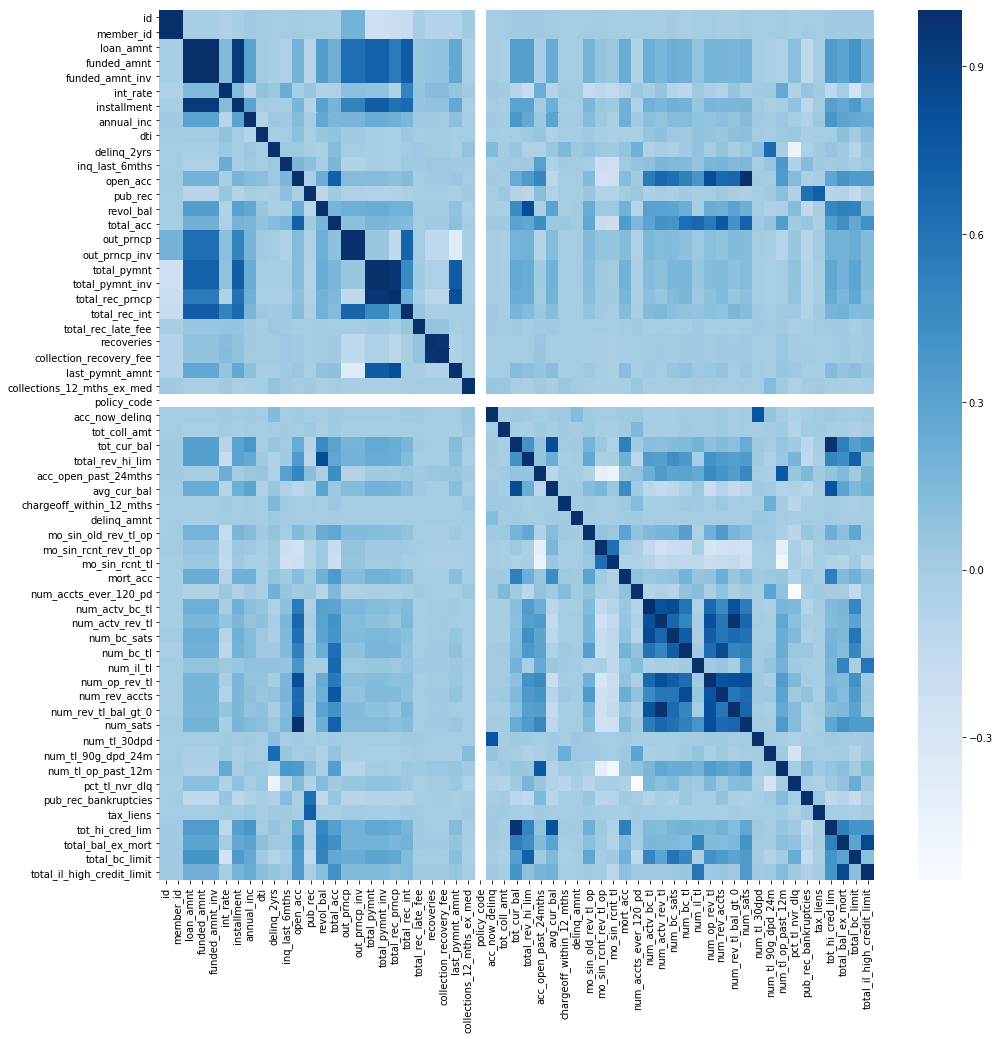

In [172]:
# check the correlation of the data
import seaborn as sns
plt.figure(figsize=(16,16))
sns.heatmap(y2015_clean.corr(), cmap="Blues")
plt.show()

From the heatmap above, we can definitely get rid of some features that have high correlation with others

In [174]:
drop_col3 = ['id', 'member_id','funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_int',
             'collection_recovery_fee', 'policy_code', 'last_pymnt_amnt', 'revol_bal', 'avg_cur_bal', 
             'mo_sin_old_rev_tl_op', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'open_acc', 'num_actv_bc_tl',
            'num_actv_rev_tl', 'num_bc_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'tot_cur_bal', 'total_bal_ex_mort']
y2015_clean.drop(drop_col3, axis=1, inplace=True)

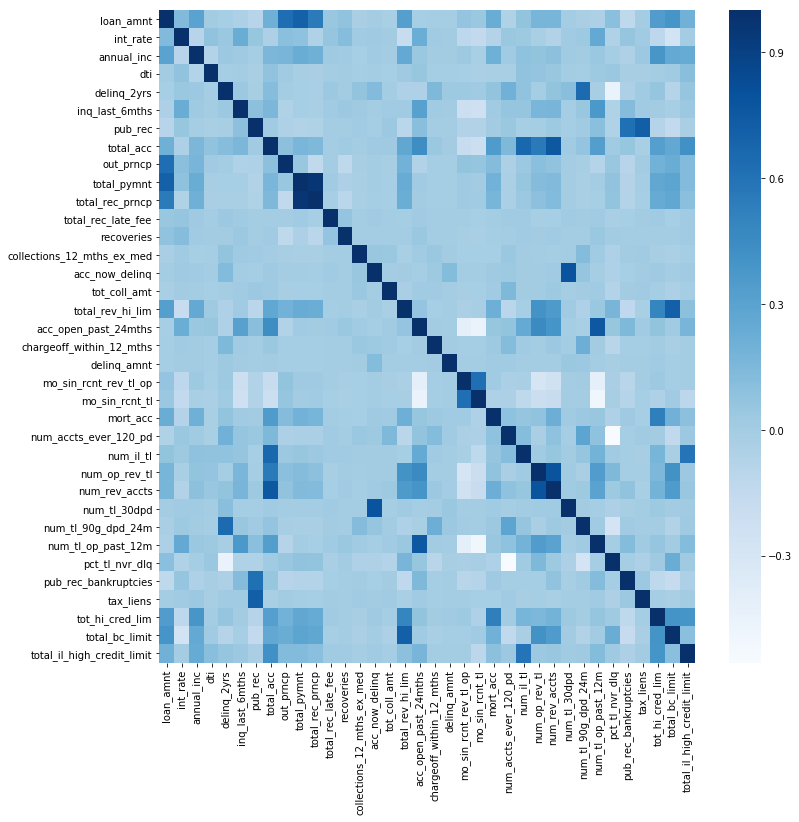

In [175]:
# reinspect the heatmap after cleaning
plt.figure(figsize=(12,12))
sns.heatmap(y2015_clean.corr(), cmap="Blues")
plt.show()

In [176]:
# drop more columns
drop_col4 = ['out_prncp', 'total_pymnt', 'total_rec_prncp', 'num_il_tl', 'num_op_rev_tl','pub_rec_bankruptcies',
            'tax_liens', 'num_tl_30dpd', 'acc_open_past_24mths', 'mo_sin_rcnt_rev_tl_op', 'tot_hi_cred_lim',
            'total_bc_limit']
y2015_clean.drop(drop_col4, axis=1, inplace=True)

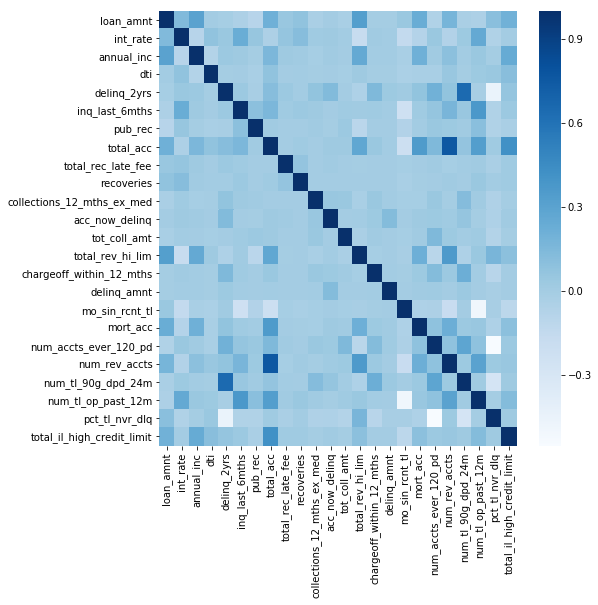

In [177]:
plt.figure(figsize=(8,8))
sns.heatmap(y2015_clean.corr(), cmap="Blues")
plt.show()

In [178]:
# seems there are three more columns need to be dropped
y2015_clean.drop(['num_rev_accts', 'delinq_2yrs', 'total_rev_hi_lim'], axis=1, inplace=True)

In [181]:
y2015_clean.dropna(inplace=True)

In [183]:
y2015_clean.head()

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,tot_coll_amt,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,total_il_high_credit_limit
0,16000.0,60 months,14.85,C,C5,MORTGAGE,48000.0,Not Verified,Dec-2015,Current,...,0.0,0.0,0.0,6.0,2.0,2.0,0.0,2.0,78.9,13400.0
1,9600.0,36 months,7.49,A,A4,MORTGAGE,60000.0,Not Verified,Dec-2015,Current,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,2.0,100.0,75635.0
2,25000.0,36 months,7.49,A,A4,MORTGAGE,109000.0,Not Verified,Dec-2015,Fully Paid,...,0.0,0.0,0.0,13.0,3.0,0.0,0.0,0.0,100.0,82117.0
3,28000.0,36 months,6.49,A,A2,MORTGAGE,92000.0,Not Verified,Dec-2015,Current,...,0.0,0.0,0.0,19.0,2.0,0.0,0.0,0.0,91.7,42503.0
4,8650.0,36 months,19.89,E,E3,RENT,55000.0,Verified,Dec-2015,Fully Paid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,100.0,18248.0


In [187]:
y2015_clean['loan_status'].head()

0       Current
1       Current
2    Fully Paid
3       Current
4    Fully Paid
Name: loan_status, dtype: object

In [199]:
# approach 6
# after feature selection, we will try to use it to predict directly without using PCA
X_6 = pd.get_dummies(y2015_clean.drop(['loan_status', 'issue_d', 'pymnt_plan'], axis=1))
y_6 = y2015_clean['loan_status']
cross_val_score(rfc, X_6, y_6, cv=10)

array([0.82768938, 0.82590834, 0.82457848, 0.8297554 , 0.82825932,
       0.82519592, 0.82172457, 0.82242857, 0.82335059, 0.80154376])

In [193]:
y2015_clean.select_dtypes(['object']).head()

,term,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,initial_list_status,last_credit_pull_d,application_type
0,60 months,C,C5,MORTGAGE,Not Verified,Dec-2015,Current,n,credit_card,w,Jan-2017,INDIVIDUAL
1,36 months,A,A4,MORTGAGE,Not Verified,Dec-2015,Current,n,credit_card,w,Jan-2017,INDIVIDUAL
2,36 months,A,A4,MORTGAGE,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,w,Jan-2017,INDIVIDUAL
3,36 months,A,A2,MORTGAGE,Not Verified,Dec-2015,Current,n,debt_consolidation,w,Jan-2017,INDIVIDUAL
4,36 months,E,E3,RENT,Verified,Dec-2015,Fully Paid,n,debt_consolidation,w,Jun-2016,INDIVIDUAL
